Fill in the missing code (#####). Here you learn to use the spearman_metric function. Check the very important question at the end.

In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import keras.backend as K
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Here you see how to calculate the spearman correlation using numpy (1a), tensors (1b) and scipy.stats.spearmanr (3).
The results are similar. The comparison is in 3.

In [2]:
#1
def spearman_correlation(predictions, targets):
    if not isinstance(predictions, pd.Series):
        predictions = pd.Series(predictions)
    ranked_preds = predictions.rank(pct = True, method = "first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

#2a
def corrcoef(x, y):
#np.corrcoef() implemented with tf primitives

    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.math.reduce_sum(xm * ym)
    r_den = tf.norm(xm) * tf.norm(ym)
    return r_num / (r_den + tf.keras.backend.epsilon())

#2b
def tf_spearman_correlation(predictions, targets):
    ranked_preds = tf.cast(tf.argsort(tf.argsort(predictions, stable = True)), targets.dtype)
    return corrcoef(ranked_preds, targets)

targets = np.array([0.0, 0.25, 0.5, 0.75, 1.0], dtype = np.float32)
predictions = np.random.rand(targets.shape[0])

print("numpy spearman:", spearman_correlation(predictions, targets))
result = tf_spearman_correlation(tf.convert_to_tensor(predictions, dtype=tf.float32), tf.convert_to_tensor(targets, dtype=tf.float32))
with tf.Session() as sess:
    scalar = result.eval()

#COMPARISON
print("tf spearman", scalar)
#3
print (spearmanr(targets,predictions))

numpy spearman: 0.7
tf spearman 0.7
SpearmanrResult(correlation=0.7, pvalue=0.1881204043741873)


Next we use tensors to program a spearman loss. Note the argsort operation in line 7, which is not differentiable. 
If you tell Keras to use this spearman_loss, it will complain about the lack of a gradient. So spearman_loss cannot be used.
The ranking step needs to substituted by a tensor operation that is similar enough and yet differentiable not available in tf 1.5.

In [3]:
def spearman_loss(y_true, y_pred):
#Generates an error due to ranking operation not being differentiable do not use
    """Spearman correlation coefficient"""

    x = y_true
    y = y_pred
    y = tf.cast(tf.argsort(tf.argsort(y, stable = True)), targets.dtype) #argsort is not a differentiable operation
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)

    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

Next we use tensors to program a spearman metric. Note the use of py_func (a shortcut).

py_func is a tf wrapper for a python function. py_func returns a tensor.
Below we use py_func to wrap around the python function spearmanr.
This use of py_func works in my setup but it does not always work.
If you have problems with it, 
just use the spearman_metric underneath (commented out) that uses tensors.

In [4]:
def spearman_metric(y_true, y_pred):
    """Spearman correlation coefficient"""

    r = tf.py_function(spearmanr, inp=[y_true, y_pred], Tout=tf.float32)
    
    return  tf.constant(1.0, dtype=y_true.dtype) - r

def spearman_metric(y_true, y_pred):
    """Spearman correlation coefficient"""

    x = y_true
    y = y_pred
    y = tf.cast(tf.argsort(tf.argsort(y, stable = True)), targets.dtype)
    xm, ym = x - K.mean(x), y - K.mean(y)
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / (r_den + K.epsilon())
    r = K.maximum(K.minimum(r, 1.0), -1.0)

    return  tf.constant(1.0, dtype=x.dtype) - K.square(r)

In [5]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

Train on 500 samples, validate on 500 samples
Epoch 1/100
500/500 [==============================] - 0s 976us/step - loss: 2.4383 - spearman_metric: 0.6995 - val_loss: 0.7682 - val_spearman_metric: 0.3047
Epoch 2/100
500/500 [==============================] - 0s 152us/step - loss: 0.5597 - spearman_metric: 0.2290 - val_loss: 0.3020 - val_spearman_metric: 0.1200
Epoch 3/100
500/500 [==============================] - 0s 120us/step - loss: 0.2255 - spearman_metric: 0.1100 - val_loss: 0.2026 - val_spearman_metric: 0.0703
Epoch 4/100
500/500 [==============================] - 0s 118us/step - loss: 0.1262 - spearman_metric: 0.0706 - val_loss: 0.1314 - val_spearman_metric: 0.0541
Epoch 5/100
500/500 [==============================] - 0s 131us/step - loss: 0.0872 - spearman_metric: 0.0546 - val_loss: 0.1042 - val_spearman_metric: 0.0430
Epoch 6/100
500/500 [==============================] - 0s 126us/step - loss: 0.0689 - spearman_metric: 0.0479 - val_loss: 0.0984 - val_spearman_metric: 0.0396


Epoch 52/100
500/500 [==============================] - 0s 138us/step - loss: 0.0038 - spearman_metric: 0.0051 - val_loss: 0.0114 - val_spearman_metric: 0.0098
Epoch 53/100
500/500 [==============================] - 0s 144us/step - loss: 0.0036 - spearman_metric: 0.0072 - val_loss: 0.0116 - val_spearman_metric: 0.0095
Epoch 54/100
500/500 [==============================] - 0s 130us/step - loss: 0.0036 - spearman_metric: 0.0047 - val_loss: 0.0111 - val_spearman_metric: 0.0094
Epoch 55/100
500/500 [==============================] - 0s 93us/step - loss: 0.0035 - spearman_metric: 0.0053 - val_loss: 0.0114 - val_spearman_metric: 0.0094
Epoch 56/100
500/500 [==============================] - 0s 144us/step - loss: 0.0033 - spearman_metric: 0.0045 - val_loss: 0.0107 - val_spearman_metric: 0.0090
Epoch 57/100
500/500 [==============================] - 0s 126us/step - loss: 0.0033 - spearman_metric: 0.0046 - val_loss: 0.0109 - val_spearman_metric: 0.0089
Epoch 58/100
500/500 [===================

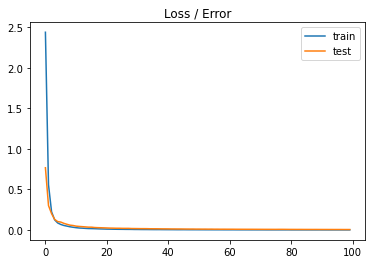

In [8]:
# mlp with scaled outputs on the regression problem with custom loss and custom metric
# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model using as loss: 'mean_squared_error', and as metric: spearman_metric
model.compile(loss="mean_squared_error",optimizer=SGD(lr=0.01, momentum=0.9),metrics= [spearman_metric])#####
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) #when using custom loss and custom metric
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) #when using custom loss and custom metric
#print('Train loss: %.3f, Test loss: %.3f' % (train_e, test_e)) 
#plot loss during training
pyplot.title('Loss / Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Does Keras use metric functions (including custom metric functions) for anything other than reporting?